Meshing

In [2]:
import os
import multiprocessing
from posix import truncate
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

is_solid = True ; 

if is_solid:
    # part_name = "origami_living_hinge.stp"
    part_name = "elastica_curve.step"
    meshing_script_name = "Living_hinge_1.geo"
    cgx_script_name = "Living_hinge_1.fbd"
    run_script_name = "run.fbd"
else:
    part_name = "origami_shell.step"
    meshing_script_name = "Living_hinge_1_shell2.geo"
    cgx_script_name = "Living_hinge_1_shell.fbd"
    run_script_name = "run_shell.fbd"

meshing_accuracy = 3
displacement_magnitude =  -0.200e-1

# Modify the geo file
with open(meshing_script_name , "r") as file:
    lines = file.readlines()

with open(meshing_script_name , "w") as file:
    for line in lines:
        if line.strip().startswith("Merge"):
            file.write(f'Merge "{part_name}";\n')
        elif line.strip().startswith("Mesh.CharacteristicLengthMax"):
            file.write(f"Mesh.CharacteristicLengthMax = {meshing_accuracy};\n")
        else:
            file.write(line) 

# Enable multithreading for ccx
os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())
snap = os.listdir(os.curdir)
os.system(f"cgx -b {cgx_script_name}")

on a Darwin machine, nodename DN0a229839.SUNet, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 Living_hinge_1.fbd opened

 reading file
 # sys gmsh part.step -clcurv -3 -o gmsh.inp -order 2
******************************************************************************
*  read ccx input                                   4.4.2002 wi              *
*                                                                            *
*                                                                            *
* -only free-format is supported. fixed format might cause a prg-crash.      *
*                                                                            *
*                                                                            *

0

In [297]:
%matplotlib widget
import dis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def regroup_faces_C3D10(elements, node_coords):
    faces = []
    for elem in elements:
        if len(elem) < 4:
            continue
        n1, n2, n3, n4 = elem[:4]  # Only use corner nodes

        try:
            # 4 triangular faces of a tetrahedron
            faces.append([node_coords[n1], node_coords[n2], node_coords[n3]])
            faces.append([node_coords[n1], node_coords[n2], node_coords[n4]])
            faces.append([node_coords[n1], node_coords[n3], node_coords[n4]])
            faces.append([node_coords[n2], node_coords[n3], node_coords[n4]])
        except KeyError as e:
            print(f"Warning: Node ID {e} not found. Skipping element.")
    return faces

def regroup_faces_CPS6(elements, node_coords):
    faces = []
    for elem in elements:
        if len(elem) != 6:
            continue  # Skip non-CPS6 elements

        try:
            face = [node_coords[elem[i]] for i in range(6)]
            faces.append(face)
        except KeyError as e:
            print(f"Warning: Node ID {e} not found. Skipping element.")
    return faces

def regroup_faces_S8R(elements, node_coords):
    """
    Build 8-node quadrilateral faces from shell elements (S8R).
    Each face will be represented by its 8 node coordinates.
    """
    faces = []
    for elem in elements:
        if len(elem) != 8:
            continue  # Skip non-S8R elements

        try:
            face = [node_coords[elem[i]] for i in range(8)]
            faces.append(face)
        except KeyError as e:
            print(f"Warning: Node ID {e} not found. Skipping element.")
    return faces

def group_faces(node_coords):
    x = [coord[0] for coord in node_coords.values()]
    y = [coord[1] for coord in node_coords.values()]
    z = [coord[2] for coord in node_coords.values()]

    group1 = {}  # fixed typo
    group2 = {}


    group1_threshold = np.max(z)
    group2_threshold = np.min(z)
    tolerance = 0.000005

    for key , values in node_coords.items():
        if np.abs( values[2] - group1_threshold ) < tolerance:
            group1[key] = values 
        elif np.abs( values[2] - group2_threshold ) < tolerance: 
            group2[key] = values 

    groups = {}
    groups["group1"] = group1
    groups["group2"] = group2

    return groups 


node_coords = {}
elements = []
plot_faces = False
isGroup_face = True

with open("all.msh", "r") as file:
    in_node_section = False
    in_element_section = False 
    for line in file:
        if line.startswith("*NODE"):
            in_node_section = True
            in_element_section = False 
            continue
        if line.startswith("*ELEMENT"):
            in_node_section = False 
            in_element_section = True
            continue
        if in_node_section:
            parts = line.strip().split(",")
            if len(parts) >= 4:
                node_id = int(parts[0])
                # x, y, z = map(float, parts[1:4])
                x, y, z = [float(val) / 1000 for val in parts[1:4]]
                node_coords[node_id] = (x, y, z)
        if in_element_section and not line.startswith("*"):
            parts = [int(p) for p in line.split(",")]
            element_id = parts[0]
            node_ids = parts[1:]
            if is_solid:
                if len(node_ids) == 10:
                    elements.append(node_ids)
            else:
                if len(node_ids) == 6:
                    elements.append(node_ids)
                elif len(node_ids)==8:
                    elements.append(node_ids)


# Separate coordinates by label sets
if isGroup_face:
    grouped_faces = group_faces(node_coords)
    upper_nset = list(grouped_faces["group1"].keys())
    lower_nset = list(grouped_faces["group2"].keys())
    basic_coords = [ node_coords[k] for k in node_coords if k not in lower_nset and k not in upper_nset ]
    upper_coords = [ node_coords[k] for k in node_coords if k in upper_nset ]
    lower_coords = [ node_coords[k] for k in node_coords if k in lower_nset ]
    upper_coords = np.array(upper_coords)
    lower_coords = np.array(lower_coords)
else:
    basic_coords = [node_coords[k] for k in node_coords ]

# Convert to numpy arrays
basic_coords = np.array(basic_coords)


In [295]:
node_coords

{1: (0.020656290257660002, 0.011707704368050001, 0.030902416205840003),
 2: (0.020656290257660002, -0.011707704368050001, 0.030902416205840003),
 3: (0.02110749836058, 0.011707704368050001, 0.03068698350669),
 4: (0.02110749836058, -0.011707704368050001, 0.03068698350669),
 5: (0.02446035400452, -3.330669073875e-18, 0.03886975075354),
 6: (0.02491156210743, -2.22044604925e-18, 0.0386543180544),
 7: (0.017517833260450002, -0.01602741983719, 0.030902416205840003),
 8: (-0.004751543799736, -0.02326317906688, 0.030902416205840003),
 9: (0.017657264232260002, -0.016456544243669997, 0.03068698350669),
 10: (-0.004612112827934, -0.02369230347337, 0.03068698350669),
 11: (0.007558665075822, -0.02326317906688, 0.03886975075354),
 12: (0.007698096047624, -0.02369230347337, 0.0386543180544),
 13: (-0.009829673893448, -0.021613194579400002, 0.030902416205840003),
 14: (-0.02359290582493, -0.002669730981653, 0.030902416205840003),
 15: (-0.01019470891671, -0.02187840804801, 0.03068698350669),
 16: 

In [296]:
x = [coord[0] for coord in node_coords.values()]
y = [coord[1] for coord in node_coords.values()]
z = [coord[2] for coord in node_coords.values()]

print( np.min(z) )
print( np.max(z) )
print( np.max(x) )
print( np.max(y) )

-4.163336342344e-19
0.04
0.025
0.023776412907379998


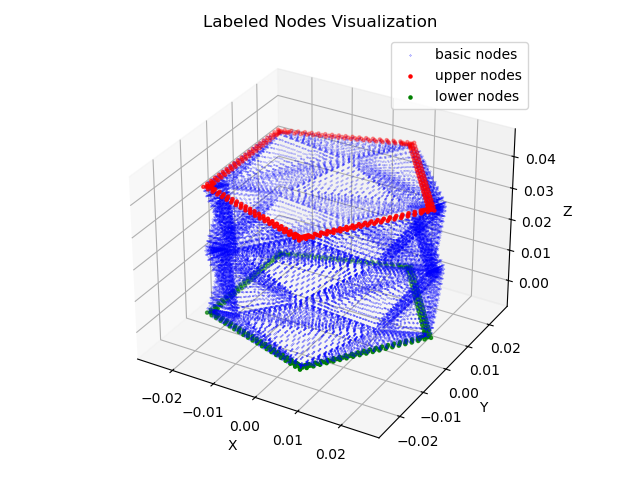

In [298]:
# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if len(basic_coords) > 0:
    ax.scatter(basic_coords[:, 0], basic_coords[:, 1], basic_coords[:, 2], c='blue',s = 0.05 , label='basic nodes')
if isGroup_face:
    if len(upper_coords) > 0:
        ax.scatter(upper_coords[:, 0], upper_coords[:, 1], upper_coords[:,2], c='red',s = 5 , label='upper nodes')
    if len(lower_coords) > 0:
        ax.scatter( lower_coords[:,0], lower_coords[:,1], lower_coords[:,2], c='green', s = 5 , label='lower nodes')

if plot_faces:
    if is_solid:
        faces = regroup_faces_C3D10(elements, node_coords)
    elif len(elements[0]) == 8:
        faces = regroup_faces_S8R(elements, node_coords)
    else:
        faces = regroup_faces_CPS6(elements, node_coords)
    poly = Poly3DCollection(faces, alpha=0.3, edgecolor='k')
    ax.add_collection3d(poly)

def set_axes_equal(ax):
    """Set equal scaling for all three axes of a 3D plot."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

ax.set_title("Labeled Nodes Visualization")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

set_axes_equal(ax)
plt.tight_layout()
plt.show()

We are analysing the effect of displacement on the face of the object. Therfore we take all the previous nodes associater with labeled faces and we relabeled them as a support set and a displacment set. 

In [273]:
import numpy as np
import json

def nodes_close_to_bar(node_coords, bars_with_points, r_tol=0.0008):
    """
    For each bar, return the set of node IDs from node_coords that lie within r_tol of the bar segment.
    
    node_coords: dict {node_id: (x, y, z)}
    bars_with_points: list of dicts with "start" and "end"
    r_tol: distance threshold [m]
    
    Returns:
        close_nodes_per_bar: list of sets of node IDs
    """
    node_ids = np.array(list(node_coords.keys()))
    node_pos = np.array([node_coords[nid] for nid in node_ids])
    close_nodes_per_bar = []

    for bar in bars_with_points:
        A = np.array(bar["start"])
        B = np.array(bar["end"])
        AB = B - A
        AB_norm2 = np.dot(AB, AB)
        if AB_norm2 == 0:
            close_nodes_per_bar.append(set())
            continue  # degenerate bar

        # Vector from A to all mesh points
        AP = node_pos - A
        t = np.clip(np.dot(AP, AB) / AB_norm2, 0, 1).reshape(-1, 1)
        proj = A + t * AB  # projection on the segment AB
        dists = np.linalg.norm(node_pos - proj, axis=1)

        # Find close node IDs
        mask = dists <= r_tol
        close_node_ids = node_ids[mask]
        close_nodes_per_bar.append(set(close_node_ids))

    return close_nodes_per_bar

# Load bars from JSON
with open("bars_with_functions.json", "r") as f:
    bar_data = json.load(f)

# node_coords must be a dict {node_id: (x, y, z)}
# Example:
# node_coords = {1: (0.0, 0.0, 0.0), 2: (0.001, 0.002, 0.0), ...}

r_tol = 0.0001  # 0.8 mm
close_node_groups = nodes_close_to_bar(node_coords, bar_data["bars"], r_tol=r_tol)

# Example: Print the node IDs close to bar 0
print(f"Bar 0 has {len(close_node_groups[0])} nearby nodes:", close_node_groups[0])

# Export mapping of bar index to list of nearby node IDs
bar_node_map = {i: list(ids) for i, ids in enumerate(close_node_groups)}


Bar 0 has 21 nearby nodes: {np.int64(7583), np.int64(7584), np.int64(7585), np.int64(7586), np.int64(7587), np.int64(7588), np.int64(7589), np.int64(7590), np.int64(7591), np.int64(7592), np.int64(7593), np.int64(7594), np.int64(7595), np.int64(7596), np.int64(7597), np.int64(7598), np.int64(7599), np.int64(7600), np.int64(7601), np.int64(586), np.int64(590)}


/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_91660/4095212291.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', len(close_node_groups))


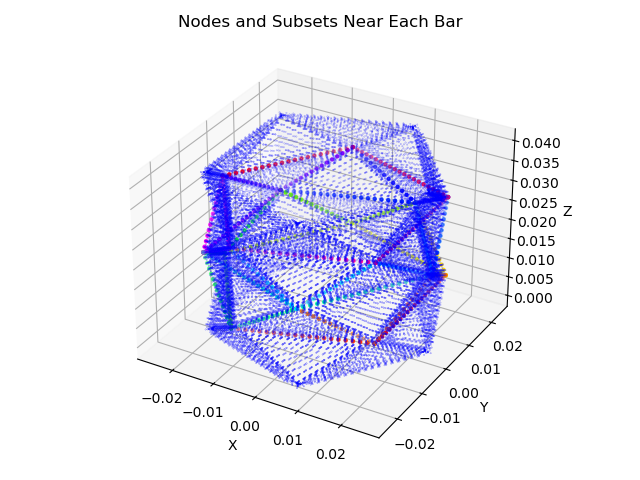

In [274]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm

def plot_node_groups(node_coords, close_node_groups):
    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # === Plot all nodes in gray ===
    all_coords = np.array(list(node_coords.values()))
    
    ax.scatter(all_coords[:, 0], all_coords[:, 1], all_coords[:, 2], c='blue', s=0.05, label='All nodes')

    # === Color for each subset ===
    cmap = cm.get_cmap('hsv', len(close_node_groups))
    node_coords_np = {k: np.array(v) for k, v in node_coords.items()}

    for i, group in enumerate(close_node_groups):
        if len(group) == 0:
            continue
        group_coords = np.array([node_coords_np[nid] for nid in group])
        ax.scatter(group_coords[:, 0], group_coords[:, 1], group_coords[:, 2],
                   color=cmap(i), s=5, label = 'BAR' )

    # Labels and styling
    ax.set_title("Nodes and Subsets Near Each Bar")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), fontsize=6)
    plt.tight_layout()
    plt.show()

plot_node_groups(node_coords, close_node_groups)

/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_91660/722996535.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', len(close_node_groups))


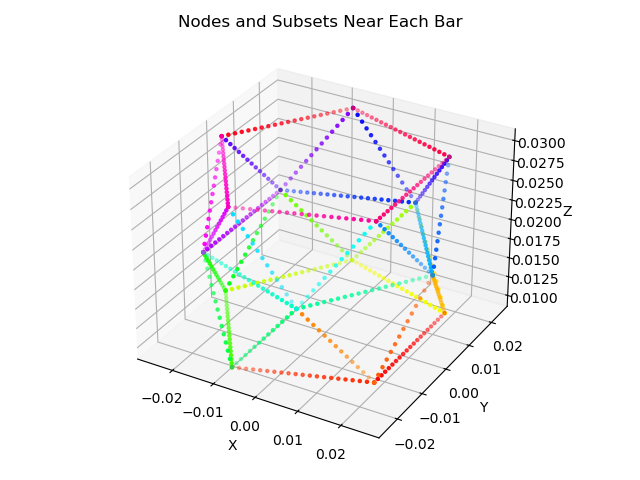

In [275]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm

def plot_node_groups(node_coords, close_node_groups):
    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # === Plot all nodes in gray ===
    all_coords = np.array(list(node_coords.values()))
    
    # ax.scatter(all_coords[:, 0], all_coords[:, 1], all_coords[:, 2], c='blue', s=0.05, label='All nodes')

    # === Color for each subset ===
    cmap = cm.get_cmap('hsv', len(close_node_groups))
    node_coords_np = {k: np.array(v) for k, v in node_coords.items()}

    for i, group in enumerate(close_node_groups):
        if len(group) == 0:
            continue
        group_coords = np.array([node_coords_np[nid] for nid in group])
        ax.scatter(group_coords[:, 0], group_coords[:, 1], group_coords[:, 2],
                   color=cmap(i), s=5, label = 'BAR' )

    # Labels and styling
    ax.set_title("Nodes and Subsets Near Each Bar")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), fontsize=6)
    plt.tight_layout()
    plt.show()

plot_node_groups(node_coords, close_node_groups)

In [285]:
node_ids = close_node_groups[0]

In [286]:
def sort_nodes_along_bar(node_ids, positions, x0, x1):
    x0 = bar_data["bars"][0]["start"]
    x1 = bar_data["bars"][0]["end"]
    positions = node_coords

    x0 = np.array(x0)
    x1 = np.array(x1)
    n = (x1 - x0) / np.linalg.norm(x1 - x0)  # Bar direction unit vector

    scalars = []

    for node_id in node_ids:
        xk = np.array(positions[node_id])
        s = np.dot(xk - x0, n)
        scalars.append((node_id, s))
    sorted_nodes = [node for node, _ in sorted(scalars, key=lambda pair: pair[1])] ; 

    return sorted_nodes, n

sorted_nodes, n = sort_nodes_along_bar( node_ids , node_coords, bar_data["bars"][0]["start"] , bar_data["bars"][0]["end"] ) ; 

In [289]:
bar_nodes_coords = []
Dl = []
L = []


for sorted_ids in sorted_nodes:
    bar_nodes_coords.append(node_coords[sorted_ids])

bar_nodes_coords = np.array([list(pt) for pt in bar_nodes_coords ])

for i in range( bar_nodes_coords.shape[0]-1 ):
    Dlk =  bar_nodes_coords[i+1] - bar_nodes_coords[i] ; 
    Lk = np.linalg.norm( Dlk )
    L.append(Lk)
    Dl.append(Dlk)

DeltaU = []
deltaU = []
epsilon = []

for i in range(len(sorted_nodes)-1):
    if( i >= 1): 
        DeltaUk = np.array(du_dict[sorted_nodes[i+1]]) - np.array(du_dict[sorted_nodes[i]])
        DeltaU.append(DeltaUk)
        deltaUk = np.dot( n , DeltaUk ) 
        deltaU.append(deltaUk)
        epsilonk = deltaUk / L[i]
        epsilon.append(epsilonk)

epsilon_average = np.mean(epsilon)

sigmas = []

for i in range(len(sorted_nodes)-1):
    if(i >= 1):
        s = np.array(stress_dict[sorted_nodes[i]])
        sigma_tensor = np.array([
            [s[0], s[3], s[5]],
            [s[3], s[1], s[4]],
            [s[5], s[4], s[2]],
        ])
        sigma_n = n @ sigma_tensor @ n
        sigmas.append(sigma_n)

sigma_average = np.mean(sigmas)


if abs(epsilon_average) > 1e-6:
    E0 = sigma_average / epsilon_average
else:
    E0 = np.nan  # or skip


In [290]:
E0

np.float64(0.0035692637771100534)

In [308]:
epsilon = []
deltaU = []
DeltaU = []
sigmas = []

for i in range(4, len(sorted_nodes)-5):
    # Displacement difference
    DeltaUk = np.array(du_dict[sorted_nodes[i+1]]) - np.array(du_dict[sorted_nodes[i]])
    DeltaU.append(DeltaUk)

    # Projected displacement
    deltaUk = np.dot(n, DeltaUk)
    deltaU.append(deltaUk)

    # Distance between nodes
    Lk = np.linalg.norm(np.array(node_coords[sorted_nodes[i+1]]) - np.array(node_coords[sorted_nodes[i]]))

    # Strain
    epsilonk = deltaUk / Lk
    epsilon.append(epsilonk)

    # Stress projection
    s = np.array(stress_dict[sorted_nodes[i]])
    print(s)
    sigma_tensor = np.array([
        [s[0], s[3], s[5]],
        [s[3], s[1], s[4]],
        [s[5], s[4], s[2]],
    ])
    sigma_n = n @ sigma_tensor @ n
    print(sigma_n)
    sigmas.append(sigma_n)

# Averages
epsilon_average = np.mean(epsilon)
sigma_average = np.mean(sigmas)

# Final E0
E0 = sigma_average / epsilon_average if abs(epsilon_average) > 1e-6 else np.nan

[-2.04781e-04 -6.18067e-04 -1.40157e-03 -1.56040e-05 -3.89420e-05
 -6.47856e-06]
-0.000618067
[-3.48824e-04 -7.55163e-04 -1.59518e-03 -2.23796e-05 -3.36030e-05
  9.39103e-07]
-0.000755163
[-3.66009e-04 -4.93678e-04 -1.10112e-03  7.37515e-06 -2.05584e-05
 -3.23353e-06]
-0.000493678
[-3.52536e-04 -4.89626e-04 -1.00935e-03  9.12894e-06 -1.21124e-05
  4.00956e-06]
-0.000489626
[-3.20792e-04 -3.82791e-04 -8.96394e-04  1.04075e-05 -4.63375e-06
  1.29208e-05]
-0.000382791
[-2.98125e-04 -3.89369e-04 -9.09495e-04  1.75673e-05 -1.87673e-06
  1.23324e-05]
-0.000389369
[-2.96163e-04 -3.54074e-04 -8.12544e-04  6.21894e-07  3.06668e-08
  8.83815e-06]
-0.000354074
[-3.23832e-04 -4.19975e-04 -9.49010e-04 -9.89605e-06  3.79105e-06
  1.52945e-05]
-0.000419975
[-2.63502e-04 -3.55366e-04 -8.63903e-04 -9.89030e-07  4.44170e-06
  2.19213e-05]
-0.000355366
[-3.63166e-04 -4.84949e-04 -9.87103e-04 -1.29612e-05  5.82298e-06
  7.04836e-06]
-0.000484949
[-4.36088e-04 -5.08786e-04 -1.09443e-03 -1.12936e-05  1.7339

In [310]:
E0

np.float64(-0.012835364298945356)

In [268]:
np.array(stress_dict[3301])

array([-4.48822e-05, -8.69662e-05, -2.40315e-04, -9.15154e-06,
        7.66262e-06, -2.22444e-06])

In [263]:
epsilon_average 

np.float64(0.008620843329542218)

In [260]:
n

array([0., 1., 0.])

In [264]:
sigma_average

np.float64(-8.698897142857144e-05)

In [279]:
sorted_nodes

[2291, 2014, 21705, 23922, 24684, 9998, 2296, 29008, 28156, 2292]

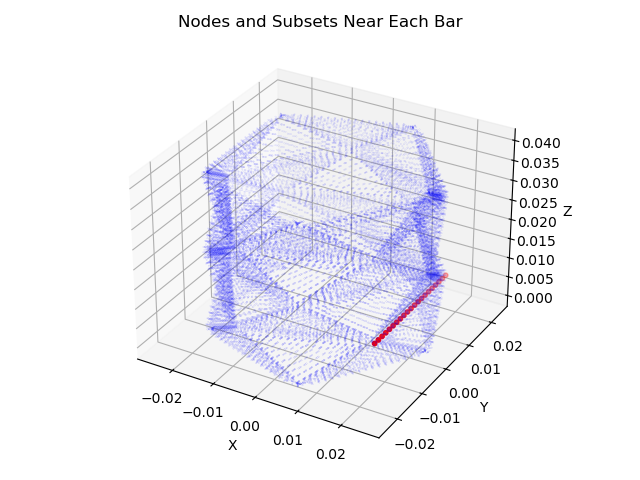

In [288]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm

def plot_node_groups(node_coords, close_node_groups):
    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(basic_coords[:, 0], basic_coords[:, 1], basic_coords[:, 2], c='blue',s = 0.005 , label='basic nodes')

    bar_nodes_coords = []

    for sorted_ids in sorted_nodes:
        bar_nodes_coords.append(node_coords[sorted_ids])

    bar_nodes_coords = np.array([list(pt) for pt in bar_nodes_coords ])
    ax.scatter( bar_nodes_coords[:,0], bar_nodes_coords[:,1], bar_nodes_coords[:,2], c='red',s = 10 , label='basic nodes')

    # Labels and styling
    ax.set_title("Nodes and Subsets Near Each Bar")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), fontsize=6)
    plt.tight_layout()
    plt.show()

    return bar_nodes_coords

bar = plot_node_groups(node_coords,sorted_nodes)

In [306]:
import re

def read_displacement_block_frd_python_index(file_path):
    """
    Reads displacements between markers:
      -5  ALL         1    2    0    0    1ALL
    and
      -3
    Converts node indexing from 1-based (CalculiX) to 0-based (Python).
    Returns: displacement_dict[node_index] = [ux, uy, uz]
    """
    displacement_dict = {}
    recording = False

    float_pattern = re.compile(r'(-?\d+\.\d+E[+-]?\d+)')

    with open(file_path, 'r') as f:
        for line in f:
            if "-5  ALL" in line:
                recording = True
                continue
            if recording and line.strip().startswith("-3"):
                break
            if recording and line.strip().startswith("-1"):
                matches = float_pattern.findall(line)
                if len(matches) == 3:
                    node_id = int(line[4:13].strip())  # Convert to Python index
                    ux, uy, uz = map(float, matches)
                    displacement_dict[node_id] = [ux, uy, uz]

    return displacement_dict

frd_path = 'Living_hinge_1_nl_el.frd'
# Run the function on the uploaded file
du_dict = read_displacement_block_frd_python_index(frd_path)

# Return preview
len(du_dict), list(du_dict.items())[:8]

(29008,
 [(1, [0.000602898, 0.000394772, -0.00426647]),
  (2, [0.00061093, -0.000402697, -0.004264]),
  (3, [0.000540284, 0.000226398, -0.00438343]),
  (4, [0.000553875, -0.00022879, -0.00437673]),
  (5, [7.10902e-05, 2.49505e-07, -0.00500164]),
  (6, [5.93156e-05, -1.06666e-07, -0.00502489]),
  (7, [0.000564548, -0.000454653, -0.0042652]),
  (8, [-0.000188363, -0.000714062, -0.00426623])])

In [229]:
du_dict

{1: [0.000125592, 7.98775e-05, -0.000842513],
 2: [0.000120345, -7.28097e-05, -0.00084919],
 3: [0.00011297, 5.13058e-05, -0.000868878],
 4: [0.000108287, -4.43637e-05, -0.000874564],
 5: [1.44163e-05, 4.838e-07, -0.000997162],
 6: [1.38669e-05, 3.04057e-07, -0.00100095],
 7: [0.000109049, -9.03307e-05, -0.000846218],
 8: [-3.44008e-05, -0.000143267, -0.000845848],
 9: [7.78955e-05, -8.66716e-05, -0.000873293],
 10: [-1.12253e-05, -0.000122707, -0.00087125],
 11: [4.92446e-06, -1.44416e-05, -0.000998645],
 12: [4.80523e-06, -1.3985e-05, -0.00100312],
 13: [-5.40733e-05, -0.00013691, -0.000843764],
 14: [-0.000141627, -1.00974e-05, -0.000845804],
 15: [-6.11289e-05, -0.000106324, -0.000869675],
 16: [-0.000114845, -2.6333e-05, -0.000871837],
 17: [-1.17735e-05, -8.7375e-06, -0.000997017],
 18: [-1.12977e-05, -8.55779e-06, -0.00100062],
 19: [-0.000144748, 7.9877e-06, -0.00084563],
 20: [-5.23497e-05, 0.000130926, -0.000848035],
 21: [-0.000117384, 2.25564e-05, -0.000872432],
 22: [-5.86

In [307]:
def read_stress_block_frd_python_index(file_path):
    """
    Reads stress tensors between markers:
      -5  SZX ...
    and
      -3
    Converts node indexing from 1-based (CalculiX) to 0-based (Python).
    Returns: stress_dict[node_index] = [sxx, syy, szz, sxy, syz, sxz]
    """
    stress_dict = {}
    recording = False

    float_pattern = re.compile(r'(-?\d+\.\d+E[+-]?\d+)')

    with open(file_path, 'r') as f:
        for line in f:
            if "-5  SZX" in line:
                recording = True
                continue
            if recording and line.strip().startswith("-3"):
                break
            if recording and line.strip().startswith("-1"):
                matches = float_pattern.findall(line)
                if len(matches) == 6:
                    node_id = int(line[4:13].strip())  # Convert to Python index
                    sxx, syy, szz, sxy, syz, sxz = map(float, matches)
                    stress_dict[node_id] = [sxx, syy, szz, sxy, syz, sxz]

    return stress_dict

# Run the function on the uploaded file
stress_dict = read_stress_block_frd_python_index(frd_path)

# Return preview
len(stress_dict), list(stress_dict.items())[:5]

(29008,
 [(1,
   [0.000100895,
    0.000375406,
    -6.40651e-05,
    6.49518e-05,
    8.95381e-05,
    -3.84428e-05]),
  (2,
   [0.000120435,
    0.000411988,
    -4.40392e-05,
    -7.80278e-05,
    -9.41201e-05,
    -3.66213e-05]),
  (3,
   [4.42878e-07,
    0.000145798,
    -2.23786e-06,
    -1.70368e-05,
    2.05486e-05,
    -5.21975e-06]),
  (4,
   [-5.04913e-06,
    9.50842e-05,
    -2.61544e-05,
    3.049e-05,
    -2.29651e-05,
    -8.73149e-06]),
  (5,
   [0.000152657,
    0.00015439,
    0.000215992,
    2.20345e-06,
    1.55692e-06,
    1.7608e-05])])

In [299]:
with open("upper.nam", "w") as file:
    file.write('**Nodes corresponding to the top surface\n')
    file.write('*NSET, NSET=Nupper\n')
    for node in upper_nset:
        file.write(f'    {node}\n')

with open("lower.nam", "w") as file:
    file.write('**Node corresponding to the bottom surface\n')
    file.write('*NSET, NSET=Nlower\n')
    for node in lower_nset:
        file.write(f'    {node}\n')

In [40]:
print( run_script_name )

run.fbd


In [303]:
os.system(f"cgx -b {run_script_name}")


************************************************************

CalculiX Version 2.22, Copyright(C) 1998-2024 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Fri May 23 18:17:45 UTC 2025

  The numbers below are estimated upper bounds

  number of:

   nodes:        29008
   elements:        29004
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            4
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:         2415
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie constr

2

In [105]:
os.system(f"cgx -b res_only.fbd")

2